In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import covid_19_shared

'''
Check this:
https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000
'''
        

In [2]:
cv_data = covid_19_shared.loadJHUData("US", True)

cv_data

,Confirmed,Recovered,Dead
Date,,,
2020-01-22,1,0,0
2020-01-23,1,0,0
2020-01-24,2,0,0
2020-01-25,2,0,0
2020-01-26,5,0,0
...,...,...,...
2020-09-19,6768119,2577446,199282
2020-09-20,6804814,2590671,199509
2020-09-21,6856884,2615949,199865


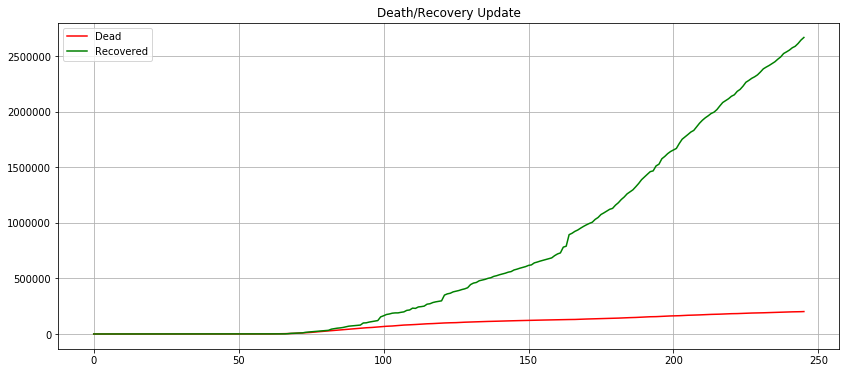

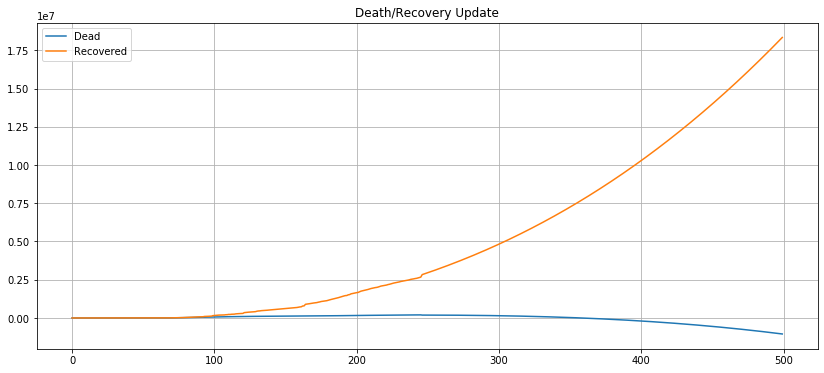

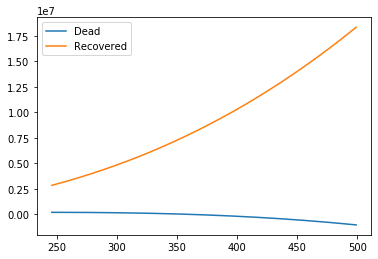

In [6]:
'''
Extrapolating predicted mortality
We'll extrapolate the curve to the point where all confirmed cases
will be completed (assuming no new cases)
'''
dead = cv_data.Dead
recovered = cv_data.Recovered

df = pd.DataFrame({"Dead":dead
                   , "Recovered" : recovered
                  }
                  , index=cv_data.index
     )
df.index = range(0, len(df.index))
df.index.name = None

real_data_num = len(cv_data.index)
extrapol_num = 500 - real_data_num

df2 = pd.DataFrame({"Dead" : [np.NaN] * extrapol_num
                   , "Recovered" : [np.NaN] * extrapol_num
                   }
                   , index=range(real_data_num, 500)
                  )
df = df.append(df2)
df

df.plot(kind='line'
        , figsize=(14, 6)
        , legend=True
        , label="Completed Cases"
        , grid = True
        , color = ['red', 'green']
        , title = "Death/Recovery Update"
        )
plt.show()

# extrapolate with curve fitting
from scipy.optimize import curve_fit

# Initial parameter guess, just to kick off the optimization
guess = (0.5, 0.5, 0.5, 0.5)

# Function to curve fit to the data (3r order polynomial)
def func(x, a, b, c, d):
    return a * (x ** 3) + b * (x ** 2) + c * x + d

fit_df = df.dropna()

# Place to store function parameters for each column
col_params = {}

# Curve fit each column
for col in fit_df.columns:
    # Get x & y
    x = fit_df.index.astype(float).values
    y = fit_df[col].values
    # Curve fit column and get curve parameters
    params = curve_fit(func, x, y, guess)
    # Store optimized parameters
    col_params[col] = params[0]

# Extrapolate each column
for col in df.columns:
    # Get the index values for NaNs in the column
    x = df[pd.isnull(df[col])].index.astype(float).values
    # Extrapolate those points with the fitted function
    df[col][x] = func(x, *col_params[col])

df1 = df[0:real_data_num]
df2 = df[real_data_num:]
df1.plot(kind='line'
        , figsize=(14, 6)
        , legend=True
#         , label="Completed Cases"
        , grid = True
#         , color = ['red', 'green']
        , title = "Death/Recovery Update"
        )
df2.plot(kind='line'
#         , figsize=(14, 6)
        )
plt.show()

